In [2]:
pack <- c("tidyverse", "plyr", "dplyr", "np", "FNN", "modelr", "rpart", "doParallel", "sandwich",
          "grf", "Matching", "boot", "ggplot2", "lattice")
invisible(suppressMessages(suppressWarnings(lapply(pack, require, character.only = TRUE))))

In [3]:
help_fun <- c("create_output_table.R", "create_output_table_JASA.R", "sim.R", "naive_ate.R", "psw_ate_boot.R", "ols_ate.R",
       "knn_ate.R", "rf_ate.R", "MSE.R", "knn_cate.R",
       "ols_cate.R", "rf_cate.R", "rf_cate_JASA.R",
       "ols_cate_JASA.R", "simAW.R", "plot_data.R", "plot_AW.R")
invisible(lapply(help_fun, source))

$\newcommand{\E}{{\rm I\kern-.3em E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
$\newcommand{\Covh}{\widehat{\Cov}}$
$\newcommand{\Varh}{\widehat{\Var}}$
$\newcommand{\betah}{\widehat{\beta}}$
$\newcommand{\Eh}{\widehat{\E}}$
$\newcommand{\YO}{Y(0)}$
$\newcommand{\YI}{Y(1)}$
$\newcommand{\indep}{\perp \!\!\! \perp}$
$\newcommand{\atehat}{\widehat{\text{ATE}}}$
$\newcommand\diff{\mathop{}\!\mathrm{d}}$
 $\newcommand{\X}{\textbf{X}}$
$\newcommand{\x}{\textbf{x}}$
$\newcommand{\ATE}{\text{ATE}}$
$\newcommand{\CATE}{\text{CATE}}$
$\newcommand{\tauhat}{\widehat{\tau}}$
$\newcommand{\naive}{\text{Naive}}$
$\newcommand{\ols}{\text{OLS}}$
$\newcommand{\knn}{\text{kNN}}$
$\newcommand{\cf}{\text{CF}}$
$\newcommand{\psw}{\text{PSW}}$

# 1 Setup and Estimation strategies

Suppose we have random sample ($\text{i.i.d.}$) of the reference population, where each observation consists of a feature vector $\X_i$, a treatment indicator $D_i$ and an outcome $Y_i$. In short: $\left\{(Y_i,\X_i,D_i)\right\}_{i=1}^{n}$.
<br>
Potentially, $\X_i = (X_{i1},\ldots,X_{id})$ is a high dimensional random vector instead of a random variable (generally, I'll use bold letters for vectors and non-bold letters for scalars).


## 1.1 Heterogeneous Treatment Effects
To develop an intuition for the importance of heterogeneity in treatment effects, we define the Average Treatment Effect ($\ATE$) and the Conditional Average Treatment Effect ($\CATE$) as follows.
<br>
&ensp;
\begin{align}
\tau&\equiv \E(\YI-\YO)\label{eq:ate}\qquad\qquad \text{(ATE)}\\[10pt]
\tau(\x)&\equiv\E(\YI-\YO\vert \X=\x)\label{eq:cate}\quad\enspace\text{(CATE)}\\[10pt]
\end{align}
<br>
<br>
These definitions are conceptually different: While the $\CATE$ is a real-valued function mapping a realization of the random vector $\X$ to a real number, the $\ATE$ is a real number. Thus, by definition, the CATE allows to have **distinct** treatment effects for different realizations of $\X$. 
<br>By the law of iterated expectation we have the following relationship between $\ATE$ and $\CATE$:

<br>
\begin{equation}
\E\left(\tau(\X)\right)=\tau \label{eq:cateate}
\end{equation}

<br>
Thus, the $\ATE$ is a summary statistic of the $\CATE$.
<br>
As with all summary statistics, it crucially depends on the distribution of treatment effects whether or not the this provides a decent summary.


## 1.2 Assumptions and Identification

Throughout we will either assume unconfoundedness (ignorability) or purely random treatment assignment in our data generatig processes (DGPs). More formally, random treatment assignment amounts to assuming 
<br>
<br>
\begin{equation}
(\YI,\YO)\enspace\indep\enspace D.\label{eq:rt}
\end{equation}
<br>
<br>
In situations usually analyzed within the social sciences, this assumption turns out to be too restrictive (see [Imbens (2004)](https://scholar.harvard.edu/imbens/publications/nonparametric-estimation-average-treatment-effects-under-exogeneity-review) for a discussion). Therefore, as we've seen throughout the course, many methods were developed under the assumption of unconfoundedness:
<br>
<br>
\begin{equation}
(\YI,\YO)\enspace\indep\enspace D\enspace \lvert\enspace X.\label{eq:uf}
\end{equation}
<br>
<br>
This is also used by [Athey and Wager (2018)](https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1319839) to develop the theory of causal trees/forests.
<br>
Within the simulation study we'll also stress the consequences for estimation when switching from (\ref{eq:rt}) to (\ref{eq:uf}). 
<br>
<br>

When it comes to estimation of both quantities, we have to make sure they're identified in the first place. 
While unconfoundedness (\ref{eq:uf}) is sufficient to identify the $\ATE$, we need an additional assumption for the $\CATE$. This is because estimating the $\CATE$ requires estimation of a function at _every_ possible point in the support of $\X$. Since the function of interest relies on quantities originating from both units in treatment and control, we have to assume that we observe both treated and control units at every possible $\X=\x$. In other words, we assume overlap.

For almost every $\x \in \text{supp}(\X)$, 
\begin{equation}
\eta < \text{Pr}(D=1 | X=x)< 1-\eta\enspace\text{for some}\enspace \eta>0 \label{eq:overlap}
\end{equation}
<br>
I will maintain this assumption throughout the remainder of this notebook.
<br>
For a proof of the identification, see [Abadie and Imbens (2006), p. 238](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1468-0262.2006.00655.x).


## 1.2 Structural representation

We can postulate the following structural equations capturing the structure of both simulation designs


\begin{align*}
X&= f_{\X}(u_\X),\\
D&= f_{D}(\X, u_D),\\
Y&= f_{Y}(\X, D, \varepsilon)\\
\end{align*}
The corresponding graph looks as follows.



<img src="Causal_graphs.png" height=300 width=300 />

Note that we could have omitted the error term $\varepsilon$ from the DAG-representation because I'll assume it to be independent of all the other variables throughout (see [Morgan and Winship (2015), p.88](https://www.cambridge.org/de/academic/subjects/sociology/sociology-general-interest/counterfactuals-and-causal-inference-methods-and-principles-social-research-2nd-edition?format=HB&isbn=9781107065079)).
The DAG-representation rightly suggests that identification is rather easy here: blocking the back-door path $D \leftarrow \X \rightarrow Y$ is sufficient and can be achieved by controllig for the observable confounder $\X$.
<br>
In addition, note that this causal graph describes a DGP with unconfoundedness rather than random treatment assignment. In the latter world, we would get rid off the path $\X \rightarrow D$.

## 1.3 Estimation Strategies

Since we'll only conduct $\ATE$ estimation in the first simulatoin setting where $X$ is one-dimensional, I'll not consider the higher dimensional case when presenting the methods below. 
<br>
In contrast, $\CATE$ estimation will also be tested on a setting with higher dimensional $\X$.

### 1.3.1 $\ATE$

In every setting of the first simulation study, $\ATE$-estimates will be obtained from five different estimators.

1.) **Naive estimator**
$$\begin{equation}
\tauhat_{\text{Naive}} = \bar{Y}_1 - \bar{Y}_{0} =\frac{1}{n_1} \sum_{i: D_i =1}^{} Y_i - \frac{1}{n_0}\sum_{i: D_i = 0}^{} Y_i \label{eq:naive},
\end{equation}$$
where $n_1 = \left|\left\{i: D_i = 1\right\}\right|$ and likewise for $n_0$.

2.) **OLS**
<br>
Depending on the option you choose in the R function below, different OLS-estimates can be obtained:
* `method_ols = "D_only"` estimates $$\begin{equation} Y_i = \alpha + \tau\cdot D_i +\varepsilon_{i,1} \label{eq:donly}\end{equation}$$
<br>
* `method_ols = "full"` estimates $$\begin{equation}Y_i = \alpha + \tau\cdot D_i+ X_i\cdot\beta +\gamma\cdot D_i\cdot(X_i-\bar{X}) +\varepsilon_{i,2}\label{eq:full}\end{equation}$$
<br>
Thus,
$
\widehat{\tau}_{\text{OLS}}
$ is just the OLS-coefficient of $D_i$.
<br>
Note that in the former case, the OLS estimate is numerically equivalent to the estimate obtained from the Naive estimator (\ref{eq:naive}).


3.) **Propensity Score Weighting (PSW) estimator** <br>
Let $\widehat{\zeta}(X_i) \equiv \widehat{\text{Pr}}(D_i = 1|X_i)$ the estimated propensity score. Then,
<br>
<br>
$$\begin{equation}
\tauhat_{\text{PSW}} = \frac{\sum_{i=1}^{n} \frac{D_i Y_i}{\widehat{\zeta}(X_i)}}{\sum_{i=1}^{n} \frac{D_i}{\widehat{\zeta}(X_i)}} - \frac{\sum_{i=1}^{n} \frac{(1-D_i ) Y_i}{1-\widehat{\zeta}(X_i)}}{\sum_{i=1}^{n} \frac{1- D_i}{1-\widehat{\zeta}(X_i)}}
\end{equation}$$
<br>
This is not the "standard" PSW-estimator, which is known to have some unattractive properties. See [Hirano, Imbens, and Ridder (2003)](https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-0262.00442), who proposed the estimator above.
<br>
<br>
I've tested several estimators for the propensity score, among them parametric models such as logit and probit but also semi- and nonparametric kernel erstimators. Since throughout the settings probit and logit give similar results and the remaining methods are incompetitively slow, I've decided to only implement logit.  

4.) **k-Nearest-Neighbor Matching (kNN)**
<br>
As we've seen in the course, matching estimators impute the counterfactual outcomes. The description below closely follows [Abadie and Imbens (2006)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1468-0262.2006.00655.x).
<br>
More specifically,
<br>
<br>
$$\widehat{Y_i}(0)=\begin{cases}
 Y_i, &\text{if}\enspace D_i = 0 \\
\frac{1}{K} \sum_{j\in \mathcal{J}_{K}(i)}^{} Y_j, &\text{if}\enspace D_i=1
\end{cases}$$
<br>
where $\mathcal{J}_{K}(i) = \left\{j_1 (i), j_2 (i),\ldots,j_K (i)\right\}$.
<br>
$j_k (i)$ is the index of the unit which is the $k$-th closest to unit $i$ in terms of covariate distance and has opposite treatment status.
<br>
<br>
Similarly,
<br>
$$\widehat{Y_i}(1)=\begin{cases}
\frac{1}{K} \sum_{j\in \mathcal{J}_{K}(i)}^{} Y_j , &\text{if}\enspace D_i = 0 \\
Y_i, &\text{if}\enspace D_i=1
\end{cases}$$
<br> This setup naturally leads to an averaging estimator of the $\ATE$:
<br>
<br>
$$\begin{equation}
\tauhat_{\text{kNN}} = \frac{1}{n}\sum_{i=1}^{n}\left(\widehat{Y_i}(1)-\widehat{Y_i}(0)\right)\end{equation}$$.

5.) **Causal Forests (CF)**
<br>
For a more detailed exposition of the ideas behind using trees for the estimation of treatment effects, please refer to Tim's notebook. The gist of the argument is as follows.
<br>
Define an index set
<br>
$$\mathcal{J}(x, d, \Pi, S) := \{i \mid X_i \in \ell(x; \Pi) \text{ and } D_i = d \text{ and } (Y_i, X_i) \in S \} \,.$$
<br>
 Given we have found a reasonable partition, say $\Pi$, we approximate $\tau$ by 
<br>
<br>
$$\hat{\tau}(x; S, \Pi) = \frac{1}{\left|\mathcal{J}(x, 1, \Pi, S)\right|} \sum_{j \in \mathcal{J}(x, 1, \Pi, S)} Y_j - \frac{1}{\left|\mathcal{J}(x, 0, \Pi, S)\right|} \sum_{j \in \mathcal{J}(x, 0, \Pi, S)} Y_j \,,$$
<br>
<br>
Obviously, the procedure aims at estimating heterogeneous treatment effects: we will obtain such an estimate for all $\x$ in the support of $\X$.
<br>
<br>
Instead of growing a single tree, however, the procedure to be used grows an ensemble of $B$ such trees, where each tree yields an estimate for every point in the support of $X$, denoted by $\widehat{\tau}_b (x)$. The forest then outputs the average 
<br>
$$\begin{equation}
\tauhat_{\text{CF}}(x) = \frac{1}{B}\sum_{b=1}^{B} \widehat{\tau}_b (x) \label{eq:caterf}
\end{equation}
$$
<br>
Using the relation between the $\CATE$ and the $\ATE$ in (\ref{eq:cateate}), we construct an estimator for the ATE as follows. 
<br>
$$
\begin{align}
\tauhat_{\text{CF}} &= \frac{1}{n}\sum_{i=1}^{n}\left(\tauhat_{\text{CF}}(X_i)\right)\\
&= \frac{1}{n}\sum_{i=1}^{n}\left(\frac{1}{B}\sum_{b=1}^{B} \widehat{\tau}_b (X_i )\right) 
\end{align}
$$

### 1.3.2 $\CATE$

For estimation of the $\CATE$, we'll restrict attention to three of the above methods.

1.) **OLS**
<br>
OLS estimates 
<br>
$$\begin{equation}
Y_i = \alpha + \tau\cdot D_i + \textbf{X}_{i} ^\intercal \beta  + D_i\cdot\left(\textbf{X}_i -\bar{\textbf{X}}\right)^\intercal\gamma + \epsilon_i \label{eq:olscate}
\end{equation}$$
<br>
How do we get to heterogeneous treatment effects from here? Recall that for an estimate of the $\ATE$ we would just extract $\tauhat_{\text{OLS}}$, which is not a function of $\x$ and therefore does not permit any statement about heterogeneity in treatment effects. The idea is based on the following observation. If we assume that the conditional expectation function is linear as we specified it, then
<br>
<br>
$$
\begin{align*}
\E(Y_i | \textbf{X}_{i} , D_i) &= \alpha + \tau\cdot D_i + \textbf{X}_{i} ^\intercal \beta  + D_i\cdot
\left(\textbf{X}_i -\bar{\textbf{X}}\right)^\intercal\gamma\\
\\
\E(Y_i (0) | \textbf{X}_{i} ) &= \alpha + \textbf{X}_{i} ^\intercal \beta\\
\E(Y_i (1) | \textbf{X}_{i} ) &= \alpha + \tau\cdot D_i + \textbf{X}_{i} ^\intercal \beta  + D_i\cdot\left(\textbf{X}_i -\bar{\textbf{X}}\right)^\intercal\gamma\\
\\
\E(Y_i (1) - Y_i(0) | \textbf{X}_{i} ) &= \tau+ \left(\textbf{X}_i -\bar{\textbf{X}}\right)^\intercal\gamma
\end{align*}
$$
<br>
Thus, estimating (\ref{eq:olscate}) by $\ols$ allows us to compute
<br>
<br>
$$
\begin{equation*}
\tauhat_{\text{OLS}}(\textbf{x}) = \widehat{\E}(Y_i (1) - Y_i(0) | \textbf{X}_{i} = \textbf{x}) = \widehat{\tau}_{\text{OLS}} + \left(\textbf{x} -\bar{\textbf{x}}\right)^\intercal\widehat{\gamma}_{\text{OLS}} \label{eq:cateols}
\end{equation*}
$$
<br>
Thus we're essentially approximating the true $\CATE$ by a linear function. Whether or not this constitutes a reasonable approximation is entirely determined by the underlying DGP.


2.) **k-Nearest-Neighbor Matching**
<br>
<br>
$$
\begin{equation}
\tauhat_{\text{kNN}}(\textbf{x}) = \frac{1}{K}\sum_{j\in \mathcal{J}_{K,1}(\textbf{x})} Y_j - \frac{1}{K}\sum_{j\in \mathcal{J}_{K,0}(\textbf{x})} Y_j  
\end{equation}
$$
<br>
$\mathcal{J}_{K,d}(\textbf{x})$ denotes the set of indices of the $K$ closest units to support point $\textbf{x}$ in terms of covariate values who have treatment status $D =d$. 
<br>
If $\text{dim}(\textbf{X}_i) > 1$, then _"close in terms of covariate values"_ means small Euclidean norm $\left\| \textbf{X}_i - \textbf{x}\right\|_{2}$

3.) **Causal Forests**
<br>
Please refer to the discussion in the last subsection (\ref{eq:caterf}).

# 2 Simulation: One-dimensional $X$

## 2.1 DGP

For nearly the whole first part of the simulations, I'll stick to models that are linear in parameters when it comes to generating the potential outcomes. In addition, the first part will exclusively consider the case in which the feature vector $X$ is of dimension $1$. The models under consideration will be special cases of the following DGP:
<br>
&ensp;
\begin{align}
Y(0)&=\gamma_0 + \gamma_1\cdot g(X)+ \gamma_2\cdot h(\gamma_3 X) +\varepsilon_0 \\
Y(1)&=\phi_0 + \phi_1\cdot f(X)+ \phi_2\cdot c(\phi_3 X)+\varepsilon_1 ,
\end{align}
<br>
where

* $\varepsilon_j \stackrel{\text{i.i.d}}{\sim} \mathcal{N}(0,1),\enspace j=0,1,\quad X \stackrel{\text{i.i.d}}{\sim} U[0,1]$
<br>
&ensp;
* $g(\cdot),h(\cdot),f(\cdot),\enspace \text{and}\enspace c(\cdot)$ are real-valued functions
<br>
&ensp;
* $\phi_j, \gamma_j \in \mathbb{R}$, $j=1,2,3$
<br>
&ensp;


In this model, $\ATE$ and $\CATE$ can be calculated as
<br>
&ensp;
\begin{align*}
\tau&=\phi_0 - \gamma_0 + \phi_1 \E(f(X))-\gamma_1 \E(g(X))+\phi_2\E(c(X))-\gamma_2\E(h(X))\\[5pt]
\tau(x)&=\phi_0 - \gamma_0 + \phi_1 f(x)-\gamma_1 g(x)+\phi_2 c(x)-\gamma_2 h(x).
\end{align*}
<br>
Thus, generally speaking, $\ATE$ and $\CATE$ will be similar if the functions do not vary too much (i.e. if the expectation of the function is close to the function's value at many $x$).

Furthermore, the propensity score is allowed to be a real-valued function of realizations of $X$, an assumption that corresponds to the concept of selection on observables.

\begin{align*}
\E(D\vert X=x)=\text{Pr}(D=1\vert X=x)&=\zeta(x)\\
&\in \left(0,1\right) \enspace \forall x \in \text{supp}(X)
\end{align*}

## 2.2 R Function

The function `create_output_table` outputs a table of results. It draws $N$ datasets, each of size $n$, from a fictitious superpopulation whose properties you can specify via the function's arguments. While running, the function will give you an idea about the runtime by displaying three different progress bars.

In [ ]:
#NOT RUN!#
#create_output_table(n = 100, N = 50, B = 1, k = 1, kC = 10, num_trees = 100,
#                           het_linear = FALSE, random_assignment = TRUE,
#                           non_linearY = FALSE, non_linearD = FALSE,
#                           method_ols = "cool",
#                           knn_se5 = TRUE, ols_se5 = TRUE, C_ols_se5 = TRUE,
#                          C_knn_se5 = TRUE, boot5 = FALSE,
#                           para = FALSE)

### 2.2.1 Input

1. **Statistical Parameters**
      * `N` is the number of datasets drawn
      * `n` is the number of observations in each of the $N$ datasets
<br>
<br>
<br>
2. **Treatment Assignment**
   1. `random_assignment` is boolean and, if
      * `TRUE`, sets $\zeta(x) = 0.5 \quad \forall x$
      * `FALSE`, sets $\zeta(x) = 0.6 x + 0.2$
<br>
   2. `non_linearD` is boolean and, if
       * `TRUE` sets $\zeta(x) = (x-0.05)^2 -0.25\cdot \left(\max\left\{0.2, \left| x\right| -0.05\right\}\right)^2 + 0.7\cdot \left(\max\left\{0.2, \left| x \right|-0.6 \right\}\right)^2$  
       * `FALSE`, `random_assignment` dictates behavior
<br>
<br>
<br>
3. **Conditional Expectation Function**
   1. `het_linear` is boolean and, if
       * `TRUE`  
       \begin{align*}
       Y(0)&=1 + 3\cdot X +\varepsilon_0 \\
       Y(1)&=5 + 5\cdot X+\varepsilon_1 ,
       \end{align*}
       <br>
       * `FALSE`
       \begin{align*}
       Y(0)&=1 + 3\cdot X +\varepsilon_0 \\
       Y(1)&=5 + 3\cdot X+\varepsilon_1 ,
       \end{align*}
       <br>
   2. `non_linearY` is boolean and, if
       * `TRUE`  
       \begin{align*}
       Y(0)&=1 + 20\cdot \sin(\pi X) +\varepsilon_0 \\
       Y(1)&=5 + 20\cdot\sin(5\pi X)+\varepsilon_1 ,
       \end{align*}
       <br>
       * `FALSE`, `het_linear` dictates behavior
<br>
<br>
<br>
4. **Tuning Parameters**
   1. k-Nearest-Neighbor matching
      * `k` number of nearest neighbors used for ATE (i.e. the cardinality of $\mathcal{J}_{K}(i)$)
      * `kC` number of nearest neighbors used for CATE (cardinality of $\mathcal{J}_{K, d}(i)$)
      <br>
   2. Random Forests
      * `num_trees` number of trees used in the random forest for both ATE and CATE
      <br>
   3. OLS
      * `method_ols` should be set to <br>
        `"D_only"` if you wish to estimate model (\ref{eq:donly}) and to <br>
        `"full"` if (\ref{eq:full}) is preferred
        <br>
        <br>
        <br>
5. **Standard Errors**  
  `ols_se5`, `C_ols_se5`, `knn_se5` and `C_knn_se5` are boolean and, if set to `TRUE`, compute an estimate of the standard deviation of the particular estimator in each run. Capital C at the beginning of the operator refers to $\CATE$.

  `boot5` refers to the Propensity Score Weighting Estimator and invokes the standard nonparametric Bootstrap to get an estimate of the standard deviation of the estimator. Correspondingly, `B` is the number of Bootstrap samples drawn in each run.
  However, a caveat is in order: Although conjectured in [Abadie and Imbens (2008)](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA6474), the nonparametric Bootstrap does not seem to be consistent here. 

  Generally speaking, standard errors are not of primary interest here, and therefore I recommend not computing them for the sake of fast computing. Especially the Bootstrapped standard error estimates increase run time dramatically.
<br>  
<br>  
6. **Computation**
      * If you download the R-Files to your local machine, setting `para = TRUE` enables parallel computing and therefore dramatically reduces runtime. Do not set to `TRUE` in the notebook. 
<br>  
<br> 
7. **Recommendations**
      * Put $n \geqslant 100$ unless you're interested in small sample properties of the estimators
      * Put $N \geqslant 500$ to keep the risk of Monte Carlo error driving the results low
      * $\text{k}=1$ is a popular and therefore recommended choice for the $\ATE$ estimation by $\text{kNN}$ ([Imbens (2004)](https://scholar.harvard.edu/imbens/publications/nonparametric-estimation-average-treatment-effects-under-exogeneity-review)) 
      * $\text{kC} \in \left\{7,20, 50, 100\right\}$ should be higher than $\text{k}$ because we aim at estimating a function. The more variable the function, the lower you might want to choose $\text{kC}$.
      * Put $\text{num_trees} \geqslant 100$. Caution: This is one of the main drivers of runtime. Can be low if number of covariates is low.
      * $B\geqslant 500$. Also one of the main drivers of runtime. Highly depends on choice for $n$. 
      * `method_ols = "full"` is recommended for two reasons.<br> First, and more importantly, it also works in some situations where `"D_only"` fails. Additionally, including few covariates can increase the precision of coefficient estimates, therefore implying lower standard errors.
<br>  
<br>  
7. **General Remarks**
<br>
Note that there is a lot of room for tailoring the methods to particular situations. For instance, one could choose the optimal $k$ and $kC$ in kNN estimation by a cross-validation procedure. Or, to not be trapped by difficult functional forms, one could estimate the potential outcome function using assumption-free non-parametric procedures instead of relying on OLS. 
<br>
For the sake of runtime and fairness, however, I've decided to rely either on default options of the functions used, or to use heuristics that have been advocated in the literature


### 2.2.2 Output

`create_output_table` returns two data frames, giving results for the $\ATE$ and $\CATE$ estimation, respectively. In the following I'll define the objects that are returned. 
<br>
<br>
**ATE**
* `avg_estimate` corresponds to the average of the estimates of $\delta$ in each simulation run. More precisely,
$$\begin{equation*}
\text{avg_estimate}\enspace \equiv \quad \overline{\widehat{\tau}} = \frac{1}{N}\sum_{j=1}^{N} \widehat{\tau}_j
\end{equation*}$$
<br>
* `sd_estimates` simply computes the standard deviation of the $N$ estimates:
$$\begin{equation*}
\text{sd_estimates} \enspace\equiv\quad \widehat{{\text{sd}}}(\widehat{\tau}) = \sqrt{\frac{1}{N-1}\sum_{j=1}^{N}\left( \widehat{\tau}_j - \overline{\widehat{\tau}}\right)^2}
\end{equation*}$$
<br>
* `avg_estimated_se` is the average of the standard error estimates obtained in each of the $N$ runs:
$$\begin{equation*}
\text{sd_estimates} \enspace\equiv\quad \overline{\widehat{\text{SE}}}(\widehat{\tau}) = \frac{1}{N}\sum_{j=1}^{N} \widehat{\text{SE}}_j(\widehat{\tau})
\end{equation*}$$
<br>
<br>
General remarks:
* If $\text{avg_estimate} \approx \text{true value}$, then we'd conclude that the method under consideration works (in terms of consistency).
* `sd_estimates` and `avg_estimated_se` should be similar, since the latter is an average over estimates of the former.
<br>
<br>

**CATE**

* `avg_mse`. In each run, the MSE is computed as:
$$\begin{equation*}
 \text{MSE}_j =\frac{1}{n}\sum_{i=1}^{n}(\tau(\X_i)_j - \widehat{\tau}(\X_i)_j)^2
\end{equation*}$$
  `avg_mse` is the simply the average
$$\begin{equation*}
\text{avg_mse}\enspace \equiv \quad \overline{\text{MSE}}=\frac{1}{N}\sum_{j=1}^{N} \text{MSE}_j
\end{equation*}$$
<br>
* `avg_mean_se` is the average of mean estimated standard error in each of the $N$ runs.
<br>
In each run, and for each support point of $X$ in that run, we can compute a point estimate of the standard error:
<br>
<br>
$$\begin{equation*}
 \widehat{\text{SE}}(\X_i)_j 
\end{equation*}$$
<br>
For one particular sample we can then compute
$$\begin{equation*}
 \overline{\widehat{\text{SE}}}_j = \frac{1}{n}\sum_{i=1}^{n} \widehat{\text{SE}}(\X_i)_j 
\end{equation*}$$
<br>
Based on that we simply average over the $N$ runs: 
$$\begin{equation*}
 \text{avg_mean_se}\enspace \equiv \quad  \text{Average}(\overline{\widehat{\text{SE}}}_j) = \frac{1}{N}\sum_{j=1}^{N}  \overline{\widehat{\text{SE}}}_j
\end{equation*}$$
<br>
General Remarks:
* Computing MSEs is very popular in the machine learning literature (e.g. [Hastie, Tibshirani, and Friedman (2005)](https://web.stanford.edu/~hastie/Papers/ESLII_3rd.pdf)) to compare and evaluate the goodness of a method. In the present setting it is a natural way to evaluate how well a function is estimated by a particular method.

As an example of how the various options you might specify translate into components of the simulation study, consider the following observations generated with the function `sim` which is also called by `create_output_table` repeatedly for the simulation study.

In [3]:
set.seed(12)
test <- sim(n = 100, het_linear = FALSE, random_assignment = TRUE, k = 1, kC = 20,
           non_linearY = FALSE, non_linearD = FALSE)
round(head(test[, 1:5], 10), 3)

Y0,Y1,X,D,Y_obs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.165,5.460,0.069,0,1.165
3.341,8.096,0.818,0,3.341
4.285,7.481,0.943,0,4.285
3.828,5.293,0.269,0,3.828
0.457,5.906,0.169,1,5.906
1.836,6.055,0.034,1,6.055
2.076,5.797,0.179,1,5.797
1.611,4.875,0.642,0,1.611
0.819,5.357,0.023,0,0.819


While $\text{Y0}$ and $\text{Y1}$ correspond to the potential outcomes, $\text{Y_obs} = Y(1)\cdot D + Y(0)\cdot (1-D)$ 

## 2.3 Results: Random Assignment, Linearity, and Constant Treatment Effects
For the first simulation, we'll study a straightforward setup to illustrate where $\CATE$ and $\ATE$ coincide.
<br>
We'll use the specification induced by setting `het_linear = FALSE` and `non_linearY = FALSE`.
<br>
This leads to the following potential outcome functions.
<br>
<br>
       \begin{align*}
       Y(0)&=1 + 3\cdot X +\varepsilon_0 \\
       Y(1)&=5 + 3\cdot X+\varepsilon_1 ,
       \end{align*}


Thus we obtain 
<br>
$$\begin{align*}
\tau &= \E(\YI-\YO)\\
     &= 4+ (3-3)\cdot\E(X)\\
     &= 4
\end{align*}$$
<br>
$$\begin{align*}
\tau(x) &= \E(\YI-\YO\vert X=x)\\
&= 4+ (3-3)\cdot \E(X\vert X=x)\\
&= 4
\end{align*}$$
<br>
In addition, we want to mimick a perfectly randomized experiment, thus setting `random_assignment = TRUE` and `non_linearD = FALSE`.
<br>
Thus, $\zeta(x) = 0.5$

Before looking at numerical results, let us first gain some intuition for this setup with a plot.

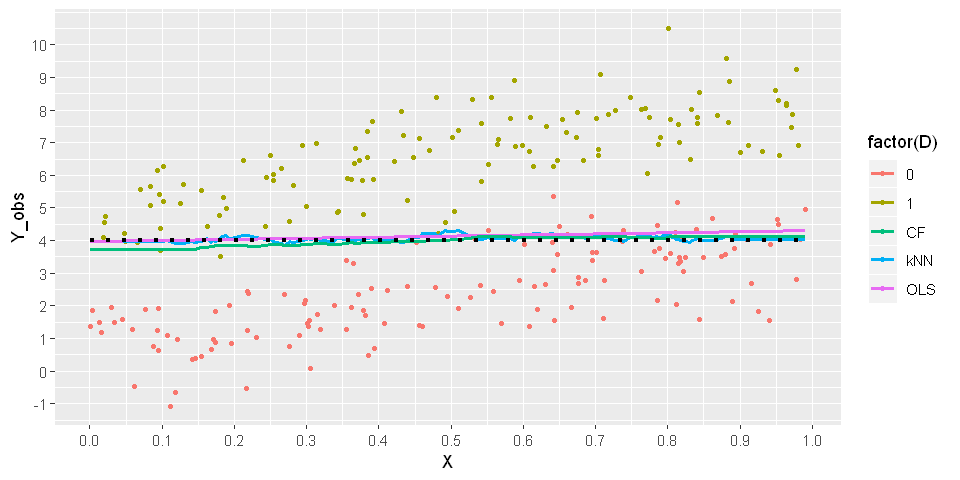

In [9]:
options(repr.plot.width=8, repr.plot.height=4)
set.seed(12)
plot_data(n=500, num_trees=100, kC=50,
                      het_linear = FALSE, random_assignment = TRUE,
                      non_linearY = FALSE, non_linearD = FALSE)


`plot_data()` creates a plot to visually explore the properties of the DGP you have specified.
<br>
In addition, it visualizes the estimated $\CATE$ function, $\tauhat(x)$, from the different methods we want to compare. 
<br>
Because `plot_data()` plots the results based on only one simulated dataset ($N=1$), however, we should not draw final conclusions from the visualization.
<br>
The true $\text{CATE}$ function is the **dotted black** line

**ATE**
<br>
As seen above, $\tau=4$. Since all of the methods except for the $\naive$ estimator can deal with unconfoundedness, the present setting using completely random treatment assignment can be seen as a warm-up where we expect all of the methods to work.
<br>
<br>
**CATE**
<br>
To start with, $\tau(x)$ is a constant in this case,  $\tau(x)=\tau=4$. 
<br>
Since both potential outcomes are linear functions of $X$, $\text{OLS}$ works perfectly fine. 
<br>
On the other hand, $\cf$ are known to struggle with smooth surfaces (see, e.g. [Hastie, Tibshirani, and Friedman (2005), p. 312](https://web.stanford.edu/~hastie/Papers/ESLII_3rd.pdf)), and would need more observations to recognize the pure linearity. Compared to $\knn$, however, $\cf$ seem to do quite well. This is because $\knn$ is an entirely non-parametric procedure which has a hard time detecting smoothness here. We could improve its performance by increasing $\text{kC}$, because averaging over more neighbors necessarily increases smoothness. At the same time, we implicitly restrict the estimated functional form by doing this.

Let's see whether our hypotheses are matched by the simulation results.

In [7]:
set.seed(12)
create_output_table(n = 500, N = 500, B = 500, k = 1, kC = 20, num_trees = 100,
                           het_linear = FALSE, random_assignment = TRUE,
                           non_linearY = FALSE, non_linearD = FALSE,
                           method_ols = "D_only",
                           knn_se5 = TRUE, ols_se5 = TRUE, C_ols_se5 = TRUE,
                           C_knn_se5 = TRUE, boot5 = FALSE, para = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


$ATE
       Description      Naive        OLS        PSW       k_NN         CF
1     avg_estimate     4.0015     4.0015    4.00324     4.0076    4.00472
2     sd_estimates     0.1216     0.1216    0.09206     0.1060    0.09715
3 avg_estimated_se     0.1185     0.1183         NA     0.1039    0.09682

$CATE
  Description        OLS       k_NN         CF
1     avg_mse    0.01676     0.1042    0.05165
2 avg_mean_se    0.08722     0.1737    0.22203

**ATE**
<br>
As expected, the distribution of the estimates of all methods are centered around the true value. 
<br>
In addition, $\naive$ and $\ols$ produce numerically equivalent estimates (see [Imbens and Rubin (2015), p. 118](https://www.cambridge.org/core/books/causal-inference-for-statistics-social-and-biomedical-sciences/71126BE90C58F1A431FE9B2DD07938AB) for a proof).
<br>
Furthermore, all estimators exhibit similar standard deviations.
<br>
<br>
**CATE**
<br>
Unsurprisingly, $\ols$ outperforms its competitors. Notably, $\cf$ is second while $\knn$ trails behind a bit.
<br>
Concerning estimation uncertainty, $\cf$ performs worse than its competitors, which is also connected to the rather low number of observations in this case. 

## 2.4 Results: Unconfoundedness, Linearity, and Constant Treatment Effects

The only thing to be changed with respect to the previous setting concerns the treatment assignment rule. We therefore set `random_assignment = FALSE`. More specifically, instead of purely random treatment assignment we're using 

$$\begin{equation*}
\zeta(x) = 0.6 x + 0.2,
\end{equation*}$$
<br>
which is an increasing function of $x$. We thus expect to see few treated units relative to untreated ones for small values of $x$ and vice versa. Despite the fact that we won't have equally many treated vs. untreated observations at the boundaries of the support of $X$, assignment rule nonetheless satisfies overlap since $\zeta(x) \in \left[0.2, 0.8\right]$.


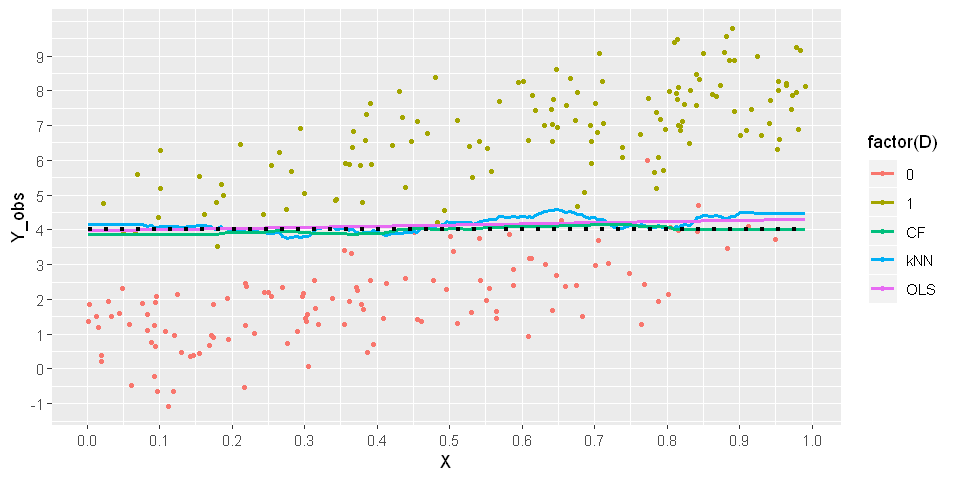

In [7]:
options(repr.plot.width=8, repr.plot.height=4)
set.seed(12)
plot_data(n=500, num_trees=100, kC=50,
                      het_linear = FALSE, random_assignment = FALSE,
                      non_linearY = FALSE, non_linearD = FALSE)


Indeed, eye-balling reveals that there are relatively few treated units relative to untreated ones for small values of $x$, and vice versa for values of $x$ close to $1$.


What effect will the change in the treatment assignment rule imply in terms of estimation performance?

Clearly, we do not have random assignment anymore: on average, units with higher values of $x$ have both higher outcomes and a higher probability of receiving treatment. In spite of that, the weaker condition of unconfoundedness is still satisfied: conditional on a realization of $X = x$, the probability of receiving treatment is the same for every unit. In other words, treatment assignment is independent of potential outcomes once we control for $X$. 
<br>
<br>
**ATE**
<br>
As we've seen in the course, random assignment is a necessary condition for the $\naive$ estimator to work. Hence, we expect it to be inconsistent whereas the $\psw$ estimator will continue to work. $\knn$ and $\cf$ were developed explicitly assuming unconfoundedness and should therefore handle this setup well. $\ols$ will not work if we do not additionally control for $X$, thereby closing the back-door path suggested in the causal graph above. 
<br>
<br>
**CATE**
<br>
As mentioned above, all of the methods can deal with unconfoundedness. Thus we expect similar results as in the last setup because overlap is still satisfied.

In [6]:
set.seed(12)
create_output_table(n = 500, N = 500, B = 500, k = 1, kC = 50, num_trees = 100,
                           het_linear = FALSE, random_assignment = FALSE,
                           non_linearY = FALSE, non_linearD = FALSE,
                           method_ols = "full",
                           knn_se5 = TRUE, ols_se5 = TRUE, C_ols_se5 = TRUE,
                           C_knn_se5 = TRUE, boot5 = FALSE,
                           para = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


$ATE
       Description      Naive        OLS        PSW       k_NN         CF
1     avg_estimate     4.5980    4.00137    4.00431     4.0051     4.0099
2     sd_estimates     0.1172    0.09793    0.09932     0.1164     0.1054
3 avg_estimated_se     0.1157    0.09554         NA     0.1122     0.1069

$CATE
  Description        OLS       k_NN         CF
1     avg_mse    0.01908    0.07363    0.04956
2 avg_mean_se    0.08687    0.07507    0.21638

**ATE**
<br>
As expected, the Naive estimator breaks down if random treatment assignment is violated.
<br>
As conjectured above, controlling for $X$ in $\ols$ estimation leaves us on the safe side.
<br>
The remaining estimators $\psw$, $\knn$, and $\cf$ work smoothly as anticipated.
Again, all estimators exhibit similar standard deviations. The uncertainty of $\ols$ estimates was reduced by the inclusion of $X$ and the interaction of $X$ and $D$.
<br>
<br>
**CATE**
<br>
Same comments as above apply.

**Remark** <br>
One may wonder whether these results are sensitive to the choice of $\zeta(x)$ for treatment assignment. The short answer is: yes they are. As we've seen in the course, the $\psw$ estimator will only work if we produce decent estimates of the propensity score. Since I've decided to use logistic regression to obtain them, they'll be rendered useless if we misspecify $\zeta(x)$ by using logistic regression (see [Morgan and Winship (2015), pp. 153-158](https://www.cambridge.org/de/academic/subjects/sociology/sociology-general-interest/counterfactuals-and-causal-inference-methods-and-principles-social-research-2nd-edition?format=HB&isbn=9781107065079) for another illustration of this problem). Exactly this is the case if you specify `non_linearD = TRUE`, which I'll leave to you to experiment with.<br>
All other methods will continue to work, especially $\ols$ if you specify `method_ols = "full"`. This is because the $\CATE$ is still a linear funtion (a constant). 

## 2.4 Results: Unconfoundedness, Linearity, and Linear Heterogeneity

This subsection sets `het_linear = TRUE` yielding the following DGP:
<br>
<br>
       \begin{align*}
       Y(0)&=1 + 3\cdot X +\varepsilon_0 \\
       Y(1)&=5 + 5\cdot X+\varepsilon_1 ,
       \end{align*}
<br>
Treated outcomes have higher slope in $X$, leading to non-constant treatment effects.
<br>
<br>
$$\begin{align*}
\tau &= \E(\YI-\YO)\\
     &= 4+ (5-3)\cdot\E(X)\\
     &= 5
\end{align*}$$
<br>
$$\begin{align*}
\tau(x) &= \E(\YI-\YO\vert X=x)\\
&= 4+ (5-3)\cdot \E(X\vert X=x)\\
&= 4+2 x
\end{align*}$$
<br>
Thus, $\ATE$ and $\CATE$ coincide if and only if $x$ is equal to the expected value of $X$, which is equal to $0.5$. This result again illustrates the relation between $\ATE$ and $\CATE$.

In addition, we're sticking to unconfoundedness instead of random treatment assignment:
<br>
$$\begin{equation*}
\zeta(x) = 0.6 x + 0.2.
\end{equation*}$$
<br>

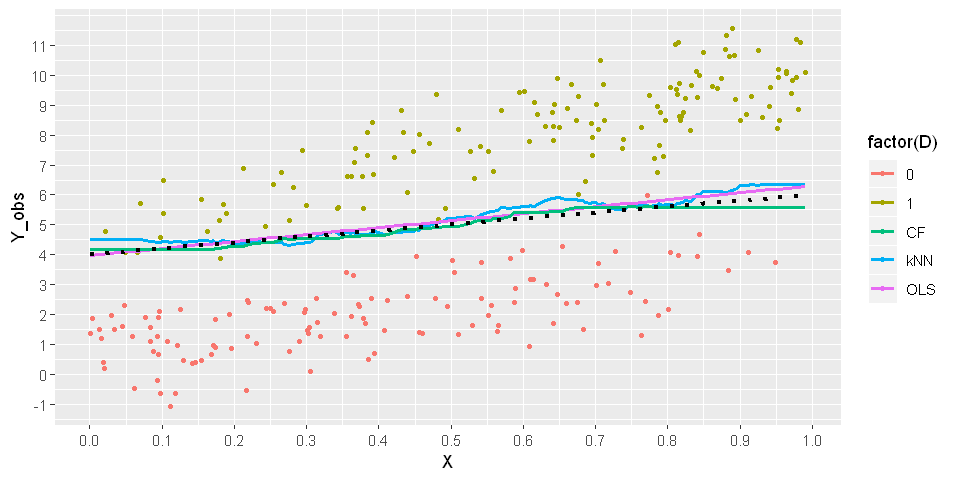

In [8]:
options(repr.plot.width=8, repr.plot.height=4)
set.seed(12)
plot_data(n=500, num_trees=100, kC=50,
                      het_linear = TRUE, random_assignment = FALSE,
                      non_linearY = FALSE, non_linearD = FALSE)

The different slopes of the potential outcomes are hardly visible to the naked eye. Nonetheless, we see the theoretical results confirmed by the true $\CATE$ function. <br>
As argued theoretically above, the $\CATE$ is now a linear function of $x$. In the previous setup it was also a linear function with a slope of $0$. We therefore do not expect any differences compared to the outcomes in the last subsection:
* The expression for the $\CATE$ estimated by $\ols$ (\ref{eq:cateols}) illustrates that the method can handle this case easily in that it allows for a linear $\CATE$.
* The other methods for $\CATE$ estimation do not rely on functional form assumptions and will therefore work. They'll probably be outperformed by $\ols$, since the target function is still linear.

**Remark**
<br>
Instead of performance comparisons among different estimators, this setup ought to make a different, albeit more important point. 
<br>
Although we expect all of the $\ATE$ estimators expect for the $\naive$ to work, we might wonder whether the $\ATE$ is still informative in this setting. Both the plot and the theoretical argument above illustrate that units with $X = x \approx 0$ exhibit a treatment effect close to $4$ while units with with $X = x \approx 1$ will see their outcome rising by $6$ if treated. 
<br> 
Thus, the informativeness of the ATE, which just averages over these outcomes to yield $5$, is severely limited. This result makes the case for explicitly allowing for heterogeneity in treatment effects when choosing an estimation strategy.  
<br> 
For the sake of completeness, have a look at the uncommented simulation results below. 

In [12]:
set.seed(12)
create_output_table(n = 500, N = 500, B = 500, k = 1, kC = 50, num_trees = 100,
                           het_linear = TRUE, random_assignment = FALSE,
                           non_linearY = FALSE, non_linearD = FALSE,
                           method_ols = "full",
                           knn_se5 = TRUE, ols_se5 = TRUE, C_ols_se5 = TRUE,
                           C_knn_se5 = TRUE, boot5 = FALSE,
                           para = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


$ATE
       Description      Naive        OLS        PSW       k_NN         RF
1     avg_estimate     5.7966    5.00122    5.00501     5.0029     5.0094
2     sd_estimates     0.1307    0.09613    0.09861     0.1158     0.1066
3 avg_estimated_se     0.1344    0.09532         NA     0.1212     0.1081

$CATE
  Description        OLS       k_NN         RF
1     avg_mse    0.01703    0.10237     0.0733
2 avg_mean_se    0.08666    0.09298     0.2271

## 2.5 Results: Unconfoundedness, Non-linearity, and non-linear Heterogeneity

So far, it was almost unfair to let the other methods compete against $\ols$ since we've been relying on linear functions for the potential outcomes, therefore equipping it with an inherent advantage. This setting will remove this advantage by setting `non_linearY = TRUE`. The DGP looks as follows.
<br>
<br>
       \begin{align*}
       Y(0)&=1 + 3X +20\cdot \sin(\pi X) +\varepsilon_0 \\
       Y(1)&=5 + 3X + 20\cdot\sin(5\pi X)+\varepsilon_1 ,
       \end{align*}
       <br>
       <br>
yielding
$$\begin{align*}
\tau &= \E(\YI-\YO)\\
     &= 4+ 20\cdot\E\left(\sin(5\pi X) - \sin(\pi X)\right)\\
     &\approx -6.185916
\end{align*}$$
<br>
and
<br>
$$\begin{align*}
\tau(x) &= \E(\YI-\YO\vert X=x)\\
&= 4+ 20\cdot \E\left(\sin(5\pi X) - \sin(\pi X)\vert X=x \right)\\
&= 4+20\cdot\left(\sin(5\pi x) - \sin(\pi x)\right),
\end{align*}$$
which is a highly non-linear a function of $x$.
<br>
<br>
As in the previous setting, the $\ATE$ is rendered uninformative. In this setting, however, the limitations of the $\ATE$ are a lot more pronounced: although many units have negative treatment effects, we find positive treatment effects close to the boundaries of the support of $X$. Therefore, we might even get the sign wrong if we predict unit-level treatment effects by using our estimate for the $\ATE$.



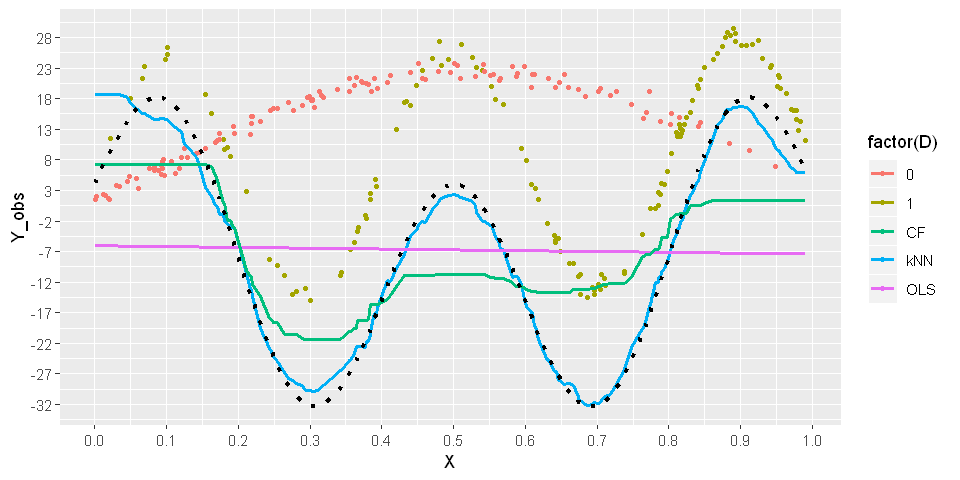

In [4]:
options(repr.plot.width=8, repr.plot.height=4)
set.seed(12)
plot_data(n=500, num_trees=100, kC=20,
                      het_linear = FALSE, random_assignment = FALSE,
                      non_linearY = TRUE, non_linearD = FALSE)

As opposed to all the previous plots, I have chosen a smaller number of nearest neighbors used for $\CATE$ estimation ($\text{kC} = 20$) in order to enable the method to capture the behavior of the function adequately. <br>
Increasing the number of observations allows $\cf$ and $\knn$ to adapt even more accurately whereas $\ols$ will stay where it is because it lacks higher order polynomials in $x$ that would enable it to better model complicated functional forms.

Researchers would probably plot the realizations of the observed outcomes beforehand and conclude that simple non-parametric tools such as local linear regression are appropriate here. However, there are three major shortcomings to this approach:
* It will not possible to obtain estimated coefficients that could be interpreted afterwards (this is also the case for $\knn$ and $\cf$)
* Even with a low-dimensional feature space ($X$ is one-dimensional here!), estimation takes a lot of time, rendering it infeasible for the simulation study
* Standard implementations of these estimators break down for reasonably high-dimensional feature spaces. For instance, the popular `loess` function in R allows for only $4$ predictors for this reason (see [Athey et al. (2019). p. 5](https://arxiv.org/pdf/1807.11408.pdf))
<br>
<br>
Let's have a look at the results.

In [10]:
set.seed(12)
create_output_table(n = 500, N = 500, B = 500, k = 1, kC = 20, num_trees = 100,
                           het_linear = FALSE, random_assignment = FALSE,
                           non_linearY = TRUE, non_linearD = FALSE,
                           method_ols = "full",
                           knn_se5 = TRUE, ols_se5 = TRUE, C_ols_se5 = TRUE,
                           C_knn_se5 = TRUE, boot5 = FALSE,
                           para = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


$ATE
       Description      Naive        OLS        PSW       k_NN         CF
1     avg_estimate    -5.5926     -7.598     -6.241    -6.1575    -6.1838
2     sd_estimates     0.9971      1.077      1.040     0.7914     0.7934
3 avg_estimated_se     0.9842      1.015         NA     1.3839     0.2125

$CATE
  Description        OLS       k_NN         CF
1     avg_mse   298.1260     8.0215    158.144
2 avg_mean_se     0.9225     0.8184      3.626

**ATE**<br>
* OLS doesn't even succeed in estimating the $\ATE$. This stems from the combination of non-linear potential outcomes and non-random assignment. If we had random_assignment, $\ols$ should produce consistent estimates of the $\ATE$ again (see [Imbens and Rubin (2015), pp. 119](https://www.cambridge.org/core/books/causal-inference-for-statistics-social-and-biomedical-sciences/71126BE90C58F1A431FE9B2DD07938AB) for a discussion of this).
* The non-parametric methods $\psw$, $\knn$, and $\cf$ work (will become clearer if you increase $n$ to, say, $1000$). 


**CATE**
<br>
As expected, $\ols$ doesn't stand a chance, while $\knn$ and $\cf$ perform comparably well. Notably, $\knn$ clearly outperforms $\cf$, a conclusion that may not hold for higher $n$.

## 2.6 Conclusion 
The most important advantage of a simulation with one-dimensional $X$ is the possibility of developing some intuition about the issues graphically. The main takeaway of the previous subsections can be summarised as follows.
* Even if we have methods that are able to produce consistent estimates of the $\ATE$, we might simply not want to do that if the $\ATE$ delivers only little information about the underlying structure of the problem. We have seen that this is especially pronounced if there is a lot of heterogeneity in treatment effects, i.e. if the mean of the treatment effects is not a good summary statistic for the distribution of the treatment effects (see also the relationship in (\ref{eq:cateate})).
* While $\ols$ is the easiest way to capture possibly heterogeneous treatment effects, its performance can be inacceptable if heterogeneity comes in a non-linear way.
* $\knn$ and $\cf$ often perform similarly well, but especially the latter might require a higher number of observations to capture smooth surfaces well. More importantly, however, they continue to work in non-linear environments. 


$\cf$'s struggle with smoothness is subject of current research (see [Athey et al. (2019)](https://arxiv.org/pdf/1807.11408.pdf)), but these methods still lack a software implementation. Future versions of this notebook thus may see $\cf$ performing even better.
 



# 3 Simulation: $d$-dimensional $X$

Random Forests and their extension to Causal Forests ($\cf$) have been advocated in settings where
* $\text{dim}(\X_i) = d$ is high
* A large number of features are not related to the outcome (sparsity)

The following setup mimicks a situation in which a researcher faces a dataset with very many covariates of which some are potentially irrelevant for the analysis to be undertaken. 

As alluded to above, this will let non-parametric methods collapse. In contrast, $\cf$ will continue to work well since they'll just ignore the irrelevant covariates (see [Athey and Imbens (2019)](https://arxiv.org/abs/1903.10075)).

The following DGP will resemble such a setting more closely.

In the interest of runtime, however, I'll not consider as many variations as in the previous chapter. 

## 3.1 DGP

We'll largely follow [Athey and Wager (2018)](https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1319839) and essentially replicate their findings here and provide some extensions. 

<br>
Throughout we randomized treatment assignment:
<br>
$$\zeta(\textbf{x})=\frac{1}{2} \enspace \forall \textbf{x}$$
<br>
Each of the features follows a uniform distribution on the unit interval, independent of everything else


$$ (X_1,\ldots, X_d) \sim U[0,1]^{d}, \quad d\geqslant 2$$

The true $\CATE$ function, $\tau(\X)$, is only supported on the first two features, $X_1$ and $X_2$. All the other features are **_completely unrelated_** to the outcome.  

$$\begin{equation*}
 \psi: \mathbb{R} \longrightarrow \mathbb{R},\quad x \mapsto 1 + \frac{1}{1+\exp{\left(-\lambda(x-\frac{1}{3})\right)}}, \quad \lambda >0
\end{equation*}$$
<br>
$$\begin{equation*}
\tau(\X) = \tau(X_1,\ldots,X_d)= \psi(X_1)\cdot\psi(X_2)
\end{equation*}$$
<br>


$\lambda$ governs the smoothness of the function.<br>
**For all the results below I implicitly assume $\lambda = 20$.** 

We generate potential outcomes such that their difference equals the true $\CATE$ function plus noise.

$$\begin{align*}
Y(0) &= -\frac{1}{2}\cdot \tau(\X) +\varepsilon_0\\ 
Y(1) &= \frac{1}{2}\cdot \tau(\X) + \varepsilon_1
\end{align*}$$
<br>
leading to
$$\begin{align*}
\tau &= \E(\tau(\X))\\
& = \int_{-\infty}^{\infty} \cdots \int_{-\infty}^{\infty} \tau(x_1,\ldots,x_n) f_{(X_1,\ldots, X_d)}(x_1,\ldots,x_d)\diff x_1 \cdots \diff x_d\\
&\approx 2.778
\end{align*}$$
and 
<br>
$$\begin{align*}
\tau(x) &= \E(Y(1)-Y(0)\vert \X=\textbf{x})\\
&= \psi(x_1)\cdot\psi(x_2)
\end{align*}$$

Again, the $\ATE$ is a single number whose informativeness crucially depends on the degree of heterogeneity which it ought to summarize. Let's have a look at the true $\CATE$ function.

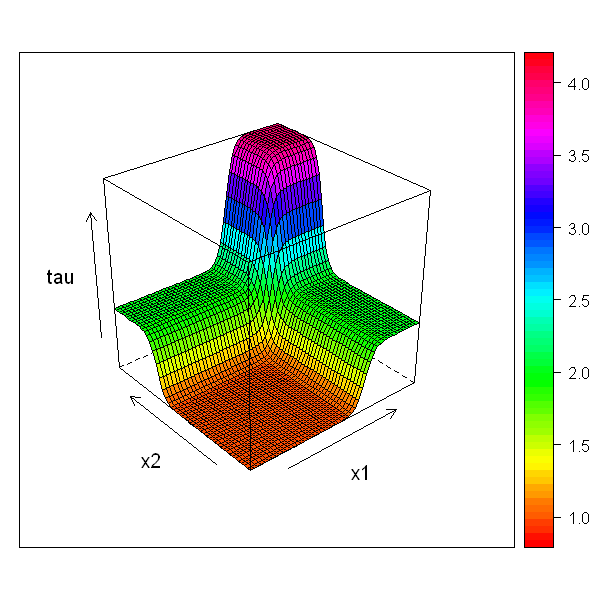

In [15]:
options(repr.plot.width=5, repr.plot.height=5)
plot_AW(lambda = 20)

We see that $\tau(X_1 ,X_2) \in [1,4]$. Units that have $(x_1, x_2) \approx (0,0)$ have a treatment effect of $1$ (ignoring the deviations that originate from the realizations of the error terms) while units with $(x_1, x_2) \approx (1,1)$ benefit from the spike of the function in that region and have a treatment effect of $4$. If either $(x_1, x_2) \approx (0,1)$ or $(x_1, x_2) \approx (1,0)$, the treatment effect is equal to $2$.
<br>
We thus conclude that, once again, the $\ATE$ only provides very limited information about unit-level treatment effects. As a consequence, we'll only focus on $\CATE$ estimation in this chapter.

Furthermore, the function's behavior is similar to that of a step function. Since $\cf$ essentially estimate the best-fitting step function, we expect them to perform well. Note, however, that the function is still continuous with $\lambda = 20$.
<br>
Decreasing $\lambda$ towards $0$ yields an almost linear function while increasing $\lambda$ reduces the smoothness of the function.

## 3.2 R Function

The following input parameters can be changed
* `N` is the number of datasets drawn
* `n` is the number of observations in each of the $N$ datasets
* `d` is the dimension of the feature vector $\X = (X_1,\ldots,X_d)$. Since $X_1$ and $X_2$ are necessary for this setup, $d\geqslant 2$
* `kC` number of nearest neighbors used for $\CATE$ estimation (cardinality of $\mathcal{J}_{K, d}(i)$)
* `num_trees` number of trees used in the random forest
<br>


In contrast to Chapter 2, I recommend using high $n$, low $N$ specifications here. If $n$ is large enough, there is not much estimation uncertainty left, thus requiring smaller $N$. If your patience permits it, however, I recommend using higher $N$.<br>
<br>
In addition, `num_trees` should be chosen according to $d$, because higher dimensions usually require more splits.

## 3.3 Results: Varying $\lambda$

We'll start with the setting that is visualized above and which exhibits medium degree of smoothness. In addition to $X_1$ and $X_2$, we'll additionally use $6$ unrelated covariates in the estimation such that $d = 8$.

We expect $\cf$ to work well due to sparsity. Since the heterogeneity of the treatment effects is not too large, $\ols$ is likely to work well, too.

In [12]:
set.seed(12)
create_output_table_JASA(n = 2000, N = 20, d = 8, num_trees = 500, kC = 20, lambda=20, C_knn_se5 = TRUE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Description,OLS,k_NN,RF
<I<chr>>,<I<chr>>,<I<chr>>,<I<chr>>
avg_mse,0.238,0.268,0.0688
avg_mean_se,NA,0.130,0.2066


$\cf$ are outperforming the other methods by a factor of around $4$, even though the degree of smoothness is medium.
<br>
As expected, $\ols$ works quite well. This is because fitting a plane isn't the worst idea for the true $\CATE$ function.
<br>
It's obviously possible to create functions that are more hostile toward $\ols$ by increasing the heterogeneity in treatment effects.
<br>
<br>
We expect the performance gap to widen if we decrease the degree of smoothness.<br>
The next results are based on $\lambda =200$:

In [13]:
set.seed(12)
create_output_table_JASA(n = 2000, N = 20, d = 8, num_trees = 500, kC = 20, lambda=200, C_knn_se5 = TRUE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Description,OLS,k_NN,RF
<I<chr>>,<I<chr>>,<I<chr>>,<I<chr>>
avg_mse,0.452,0.446,0.0759
avg_mean_se,NA,0.132,0.1983


As expected, $\cf$ extended its lead while $\ols$ and $\knn$ perform equally bad.

The last set of results will use $\lambda =2$. By manipulating the plot above you can see that this corresponds to an essentially linear target function. Hence, $\ols$ will probably outperform $\cf$ and $\knn$

In [16]:
set.seed(12)
create_output_table_JASA(n = 2000, N = 20, d = 8, num_trees = 500, kC = 20, lambda=2, C_knn_se5 = TRUE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Description,OLS,k_NN,RF
<I<chr>>,<I<chr>>,<I<chr>>,<I<chr>>
avg_mse,0.0155,0.106,0.0414
avg_mean_se,NA,0.117,0.1502


While $\ols$ outperforms its competitors as expected, $\cf$'s performance does not deteriorate at the rate $\ols$'s did before:<br>
While $\cf$ improve over $\ols$ by a factor of $7$ in the $\lambda  = 200$ setting, $\ols$ improves over $\cf$ merely by a factor of $4$ under smoothness ($\lambda = 2$). 

## 3.4 Results: Varying $d$ and $n$

If $d$ gets large relative to $n$, then $\ols$ is well known to struggle. Additionally, in a more realistic setting, some elements of the feature vector $\X$ would most likely exhibit pairwise correlations. This would further deteriorate $\ols$'s performance. For this subsection we'll maintain $\lambda=20$.

Only implementing the former hypothesis produces the following results:

In [18]:
set.seed(12)
create_output_table_JASA(n = 250, N = 100, d = 100, num_trees = 1000, kC = 20, lambda=20, C_knn_se5 = TRUE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Description,OLS,k_NN,RF
<I<chr>>,<I<chr>>,<I<chr>>,<I<chr>>
avg_mse,6.64,0.865,0.952
avg_mean_se,NA,0.128,0.208


Further increasing $d$ will let $\ols$ collapse.<br>
Generally, this setting is very hostile due to the low number of observations. Besides the obvious deterioration of $\ols$'s performance, this is also clear from the $\knn$ and $\cf$ figures.

## 3.5. Conclusion

The simulation study in this chapter moves us closer to reality in the sense that nowadays datasets tend to increase in size. Both dimensions, the number of observations and the number of covariates, are usually affected. This permits researchers to explore heterogeneity in treatment effects because subgroups are still likely to have many "members" (see [Athey and Wager (2018)](https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1319839)).
<br>
From the results in this chapter, but also from those obtained previously, one can conclude that researchers should add Causal Forests to their everyday toolkit if they plan to analyze heterogeneity in treatment effects.

More specific findings include:

* In settings with sparsity, $\cf$ can improve a lot upon both $\knn$ and $\ols$. The difference is particularly startling if $n$ is high.
* The difference depends on the degree of smoothness of the $\CATE$ function. Very smooth settings usually benefit linear methods. But even then $\cf$ performed better than $\knn$, its only non-parametric competitor.
* Even in very hostile environments with very many covariates paired with few observations, $\cf$ give reasonable results
